In [1]:
import sqlite3
import pandas as pd
import random
import numpy as np
import xgboost as xgb

from sklearn import utils, model_selection, tree, ensemble

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\denvo\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
con = sqlite3.connect("vk_data.db")
df_vk_pages = pd.read_sql("SELECT * from VkPages", con)
df_vk_photos = pd.read_sql("SELECT * from Photos", con)
df_vk_walls = pd.read_sql("SELECT * from VkWalls", con)

In [4]:
df_vk_pages.head()

,id,page_id,pagename,target
0,1,2445590,Сергей Надточий,0
1,2,3292776,Евгений Малеванчук,1
2,3,3485629,Вячеслав Каталкин,1
3,4,3486343,Александр Лобанов,0
4,5,4406445,Александр Евсюков,1


In [5]:
del df_vk_photos['id']

In [6]:
del df_vk_walls['id']

In [7]:
df_vk_photos.rename({'page_id':'id'}, axis=1, inplace=True)
df_vk_walls.rename({'page_id':'id'}, axis=1, inplace=True)

In [8]:
df_vk_photos.head()

,id,photo_id,count_photos
0,1,2445590,0
1,2,3292776,73
2,3,3485629,37
3,4,3486343,123
4,5,4406445,45


In [9]:
df_vk_walls.head()

,id,wall_id,posts_count,likes_count,reposts_count
0,1,2445590,25,56,5
1,2,3292776,364,1532,55
2,3,3485629,118,609,24
3,4,3486343,1281,2314,70
4,5,4406445,204,1526,33


In [10]:
df_vk_pages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 4 columns):
id          155 non-null int64
page_id     155 non-null object
pagename    155 non-null object
target      155 non-null int64
dtypes: int64(2), object(2)
memory usage: 4.9+ KB


In [11]:
df_vk_photos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 3 columns):
id              155 non-null object
photo_id        155 non-null object
count_photos    155 non-null int64
dtypes: int64(1), object(2)
memory usage: 3.7+ KB


In [12]:
df_vk_walls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 5 columns):
id               149 non-null object
wall_id          149 non-null object
posts_count      149 non-null int64
likes_count      149 non-null int64
reposts_count    149 non-null int64
dtypes: int64(3), object(2)
memory usage: 5.9+ KB


In [13]:
df_page_info = pd.merge(df_vk_photos, df_vk_walls, on='id')

In [14]:
df_page_info.head()

,id,photo_id,count_photos,wall_id,posts_count,likes_count,reposts_count
0,1,2445590,0,2445590,25,56,5
1,2,3292776,73,3292776,364,1532,55
2,3,3485629,37,3485629,118,609,24
3,4,3486343,123,3486343,1281,2314,70
4,5,4406445,45,4406445,204,1526,33


In [15]:
df_vk_pages.head()

,id,page_id,pagename,target
0,1,2445590,Сергей Надточий,0
1,2,3292776,Евгений Малеванчук,1
2,3,3485629,Вячеслав Каталкин,1
3,4,3486343,Александр Лобанов,0
4,5,4406445,Александр Евсюков,1


In [16]:
df_page_info['id'] = pd.to_numeric(df_page_info['id'])

In [17]:
df = pd.merge(df_vk_pages, df_page_info, on='id')

In [18]:
del df['photo_id']

In [19]:
del df['wall_id']

In [20]:
df_1 = df[df['target'] == 1]

In [21]:
df_1.shape

(39, 8)

In [22]:
df_0 = df[df['target'] == 0]

In [23]:
df_0 = df_0.iloc[71:111]

In [24]:
df_0.shape

(39, 8)

In [25]:
df_data = pd.concat([df_0, df_1])

In [26]:
df_data = utils.shuffle(df_data)

In [27]:
train = df_data[df_data.columns[~df_data.columns.isin(['target'])]]

In [28]:
target = df_data['target']

In [29]:
train = train.iloc[:, 3:]

## Обучение на основе модели решающего дерева

In [36]:
clf_tree = tree.DecisionTreeClassifier() # без ограничения глубины дерева, с большой вероятностью получаем переобученную модель

In [37]:
tree_scoring = model_selection.cross_val_score(clf_tree, train, target, scoring='accuracy', cv=5)

In [38]:
tree_scoring.mean()

0.6535714285714286

### Дерево ограниченной глубины

In [40]:
depth = np.array(range(1, 12, 1))

In [50]:
scoring = []
for max_depth in depth:
    clf_tree = tree.DecisionTreeClassifier(max_depth=max_depth)
    tree_scoring = model_selection.cross_val_score(clf_tree, train, target, scoring='accuracy', cv=5)
    scoring.append(tree_scoring.mean())

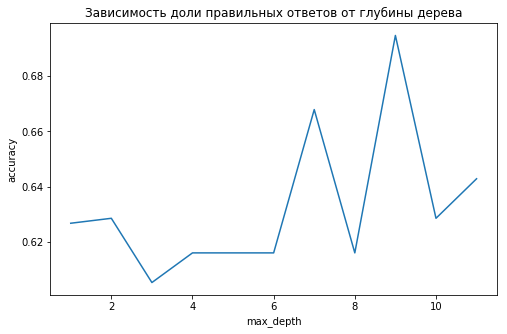

In [51]:
pyplot.figure(figsize=(8, 5))
pyplot.plot(depth, scoring)
pyplot.xlabel('max_depth')
pyplot.ylabel('accuracy')
pyplot.title('Зависимость доли правильных ответов от глубины дерева')
pyplot.show()

Доля правильных ответов при глубине дерева равным 9

In [52]:
clf_tree = tree.DecisionTreeClassifier(max_depth=9)

In [53]:
tree_scoring = model_selection.cross_val_score(clf_tree, train, target, scoring='accuracy', cv=5)

In [54]:
tree_scoring.mean()

0.6803571428571429

Оценим данный алгоритм при глубине равным 6 по другим метрикам качества

1. Точность (precision)

In [55]:
tree_scoring = model_selection.cross_val_score(clf_tree, train, target, scoring='average_precision', cv=5)

In [56]:
tree_scoring.mean()

0.6375

2. Полнота (recall)

In [60]:
tree_scoring = model_selection.cross_val_score(clf_tree, train, target, scoring='recall', cv=5)

In [61]:
tree_scoring.mean()

0.5642857142857143

3. Гармоническое среднее (F-мера)

In [62]:
tree_scoring = model_selection.cross_val_score(clf_tree, train, target, scoring='f1', cv=5)

In [63]:
tree_scoring.mean()

0.619047619047619

## Обучение на основе модели случайного леса

Случайный лес с малой глубиной деревьев

In [64]:
rf_classifier_low_depth = ensemble.RandomForestClassifier(n_estimators=50, max_depth=2)

In [65]:
rf_scoring = model_selection.cross_val_score(rf_classifier_low_depth, train, target, scoring='accuracy', cv=5)

In [66]:
rf_scoring.mean()

0.6696428571428571

Случайный лес с глубиной деревьев, равной 5

In [67]:
rf_classifier = ensemble.RandomForestClassifier(n_estimators=50, max_depth=6)

In [68]:
rf_scoring = model_selection.cross_val_score(rf_classifier, train, target, scoring='accuracy', cv=5)

In [69]:
rf_scoring.mean()

0.7035714285714285

## Градиентный бустинг

In [70]:
xgb_classifier = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, min_child_weight=3)

In [71]:
xgb_scoring = model_selection.cross_val_score(xgb_classifier, train, target, scoring='accuracy', cv=5)

In [72]:
xgb_scoring.mean()

0.7410714285714286